## EventNet Creation

EventNet consists of 2 models: a masking model and a binary classification model. In order to mask potential event-related deformation in interferograms, a masking model is required. An event presence model is then trained in order automatically provide a probabilistic answer on whether there is an event in the masked image. 

Thus, the four main steps are:
1. Create a Dataset with Simulated Wrapped Interferograms and their Masks
2. Train a masking model in the Simulated Masking Dataset
3. Create a Binary Classification Dataset of Masks and their Presence
4. Train a Binary Classification Model from the Mask/Presence Dataset

### Imports

In [33]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

import numpy as np
import matplotlib.pyplot as plt

from os import environ

environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from src.config    import SYNTHETIC_DIR
from src.io        import make_simulated_dataset, split_dataset, make_simulated_binary_dataset
from src.training  import train
from src.inference import test_masking, plot_imgs
from src.sarsim    import gen_simulated_deformation, gen_sim_noise
 
plt.rcParams['figure.figsize']  = (16,8)

### Simulated Events

By using the <i><b>gen_simulated_deformation</b></i> and <i><b>gen_sim_noise</b></i> functions, we can create simulated interferogram datasets containing "Positives" which contain events and "Negatives" which contain noise. <i><b>gen_simulated_deformation</b></i> generates our "Positive" training examples and supports 'quake', 'dyke', and 'sill' event types. <i><b>gen_sim_noise</b></i> generates our "Negative" training images with either atmospheric and topographic noise or gaussian noise. The gaussian noise is primarily used as a negative representing unmasked incoherence.

Each of these functions returns 4 things: an unwrapped phase image, a deformation mask, a wrapped image, and a presence value. These are used as follows:
- <b>Unwrapped</b>: Only used as a visual aid. Since gen_simulated_deformation contaminates this image, you must use the Okada class manually if you want an accurate displacement image.
- <b>Wrapped</b>: This is the primary input for training the masking model. Wrapped images are turned into deformation masks.
- <b>Deformation Mask</b>: This is used as a ground truth for training. Pixels are set to 1 where there is an event and its phase is greater than 2π.
- <b>Presenc</b>e: [1] if the image contains a deformation event (it was from gen_simulated_deformation), otherwise its [0] (it was from gen_sim_noise).



Deformation Presence: [1]
Mixed Noise Presence: [0]
Gauss Noise Presence: [0]


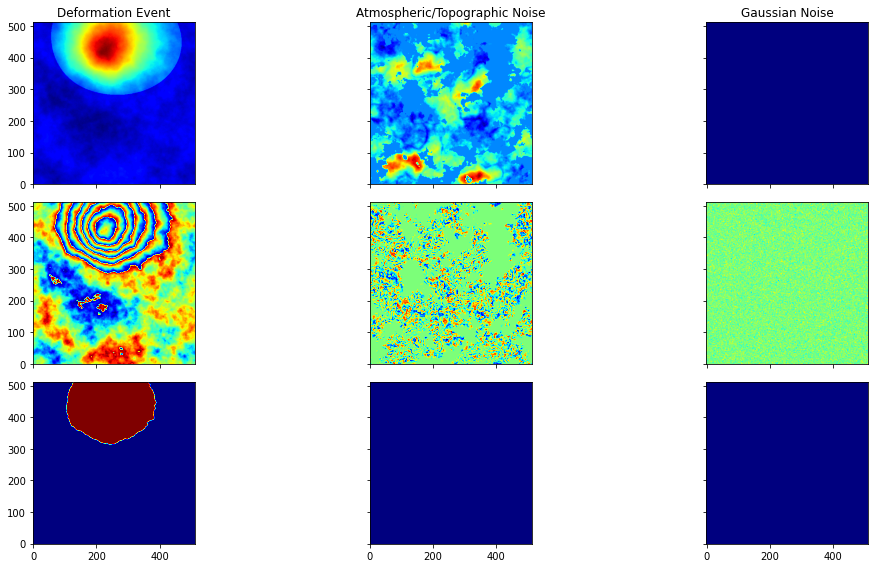

In [44]:
seed       = 123456
tile_size  = 512
event_type = 'quake'

unwrapped_def, masked_def, wrapped_def, presence_def = gen_simulated_deformation(
    seed       = seed,
    tile_size  = tile_size,
    event_type = event_type
)
unwrapped_mix, masked_mix, wrapped_mix, presence_mix = gen_sim_noise(
    seed      = seed,
    tile_size = tile_size
)
unwrapped_gsn, masked_gsn, wrapped_gsn, presence_gsn = gen_sim_noise(
    seed          = seed,
    tile_size     = tile_size,
    gaussian_only = True
)

print(f"Deformation Presence: {presence_def}")
print(f"Mixed Noise Presence: {presence_mix}")
print(f"Gauss Noise Presence: {presence_gsn}")

_, [
    [axs_unwrapped_def, axs_unwrapped_mix, axs_unwrapped_gsn],
    [axs_wrapped_def, axs_wrapped_mix, axs_wrapped_gsn],
    [axs_mask_def, axs_mask_mix, axs_mask_gsn]
   ] = plt.subplots(3, 3, sharex=True, sharey=True, tight_layout=True)

axs_unwrapped_def.set_title("Deformation Event")
axs_unwrapped_mix.set_title("Atmospheric/Topographic Noise")
axs_unwrapped_gsn.set_title("Gaussian Noise")

axs_unwrapped_def.imshow(unwrapped_def, origin='lower', cmap='jet')
axs_unwrapped_mix.imshow(unwrapped_mix, origin='lower', cmap='jet')
axs_unwrapped_gsn.imshow(unwrapped_gsn, origin='lower', cmap='jet')    
axs_wrapped_def.imshow(wrapped_def, origin='lower', cmap='jet')
axs_wrapped_mix.imshow(wrapped_mix, origin='lower', cmap='jet')    
axs_wrapped_gsn.imshow(wrapped_gsn, origin='lower', cmap='jet')
axs_mask_def.imshow(masked_def, origin='lower', cmap='jet', vmin=0.0, vmax=1.0)
axs_mask_mix.imshow(masked_mix, origin='lower', cmap='jet', vmin=0.0, vmax=1.0)
axs_mask_gsn.imshow(masked_gsn, origin='lower', cmap='jet', vmin=0.0, vmax=1.0)

plt.show()

### Create Dataset of Simulated Events

The <i><b>make_simulated_dataset</b></i> function is used to generate the datasets for training the masking model. It creates a dataset of specified size with a positive-to-negative ratio of 60/40, where 30% of the negatives are atmospheric noise and 10% are gaussian noise. The ratios can be modified easily in the source code, but the default ratios are what has worked best so far.

<i>Note</i>: while you can train a binary model with the same dataset that you train the masking model with, it is not recommended.

In [31]:
name       = "Test_Dataset" 
amount     = 1000            # The number of images to generate. ~1500 is sufficient for a decent model.
seed       = 0               # The seed for the random number generators
tile_size  = 512             # The size of the tiles to generate
crop_size  = 512             # Crop size for model (same as tile_size for our U-Net currently)
split      = 0.1             # The percentage of the dataset to use for validation

name, count, dir_name, distribution, dataset_info = make_simulated_dataset(
    name,
    SYNTHETIC_DIR,
    amount,
    seed,
    tile_size,
    crop_size
)

dataset_path = SYNTHETIC_DIR.__str__() + '/' + dir_name

num_train, num_validation = split_dataset(dataset_path, split)

print("")
print(f"Dataset Path:      {dataset_path}")
print(f"Train Amount:      {num_train}")
print(f"Validation Amount: {num_validation}")

Generated 10 of 100 simulated interferogram pairs.
Generated 20 of 100 simulated interferogram pairs.
Generated 30 of 100 simulated interferogram pairs.
Generated 40 of 100 simulated interferogram pairs.
Generated 50 of 100 simulated interferogram pairs.
Generated 60 of 100 simulated interferogram pairs.
Generated 70 of 100 simulated interferogram pairs.
Generated 80 of 100 simulated interferogram pairs.
Generated 90 of 100 simulated interferogram pairs.
Generated 100 of 100 simulated interferogram pairs.

Dataset Path:      /home/andrew/repos/AI-Event-Monitoring/data/working/synthetic/Test_Dataset_amount100_seed195546
Train Amount:      92
Validation Amount: 8


### Train UNet Masking Model

The main model we use for masking is a form of U-Net. It is also possible to use a ResNet-like model by switching "unet" to "resnet", but the "unet" tends to produce better results in less time. The default hyperparameters here should be sufficient for getting good results.

In [32]:
model_name    = "Test_Model"
model_type    = "unet"
dataset_path  = dataset_path
input_shape   = 512
epochs        = 10
filters       = 64
batch_size    = 1
learning_rate = 1e-4
use_wandb     = False
using_aws     = False
using_jupyter = True
logs_dir      = ""

mask_model, mask_history = train(
    model_name,
    dataset_path,
    model_type,
    input_shape,
    epochs,
    filters,
    batch_size,
    learning_rate,
    use_wandb,
    using_aws,
    using_jupyter,
    logs_dir
)

def print_model_info(model, history):

    losses     = history.history['loss']
    val_losses = history.history['val_loss']

    min_loss     = min(losses)
    min_val_loss = min(val_losses)

    min_loss_at     = losses.index(min_loss)
    min_val_loss_at = val_losses.index(min_val_loss)

    summary_list = []
    model.summary(print_fn = lambda x: summary_list.append(' ' + x)) 
    summary_string = '\n'.join(summary_list[1:])

    print(
        f'\n',
        f'Model Name:    {model_name}\n',
        f'Model Type:    {model_type}\n',
        f'\n',
        f'Minimum Training Loss:   {min_loss: 0.15f} at epoch {min_loss_at}.\n',
        f'Minimum Validation Loss: {min_val_loss: 0.15f} at epoch {min_val_loss_at}.\n'
        f'\n',
        f'All Training Losses:\n {losses}\n',
        f'\n',
        f'All Validation Losses:\n {val_losses}\n',
        f'\n',
        f'Model Parameters from History:\n {history.params}\n',
        f'\n',
        f'Model Summary:\n{summary_string}\n'
    )

print_model_info(mask_model, mask_history)

2022-11-22 21:02:49.782876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 21:02:49.788337: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 21:02:49.788922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-22 21:02:49.789274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built witho

Epoch 1/10


2022-11-22 21:02:53.263168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-11-22 21:02:53.957963: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


92/92 [==============================] - ETA: 0s - loss: 0.2133 - mean_squared_error: 0.6095 - mean_absolute_error: 0.4455
Epoch 1: val_loss improved from inf to 0.10545, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:03:14.619226: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 27s 121ms/step - loss: 0.2133 - mean_squared_error: 0.6095 - mean_absolute_error: 0.4455 - val_loss: 0.1055 - val_mean_squared_error: 0.2167 - val_mean_absolute_error: 0.3162
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.0810 - mean_squared_error: 0.1647 - mean_absolute_error: 0.2653
Epoch 2: val_loss improved from 0.10545 to 0.07401, saving model to ./data/output/models/checkpoints/Test_Model
INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 9s 101ms/step - loss: 0.0810 - mean_squared_error: 0.1647 - mean_absolute_error: 0.2653 - val_loss: 0.0740 - val_mean_squared_error: 0.1494 - val_mean_absolute_error: 0.2572
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.0653 - mean_squared_error: 0.1315 - mean_absolute_error: 0.2308
Epoch 3: val_loss

### Run Inference on a Simulated Event with the Masking Model

Now that we have a masking model, we can do a basic evaluation of our model using the simulated data. As you will see, the U-Net outputs pixel values that can range from slightly below 0 to slightly above 1. These values can be roughly thought of as a confidence in whether the pixel represents deformation from an event.

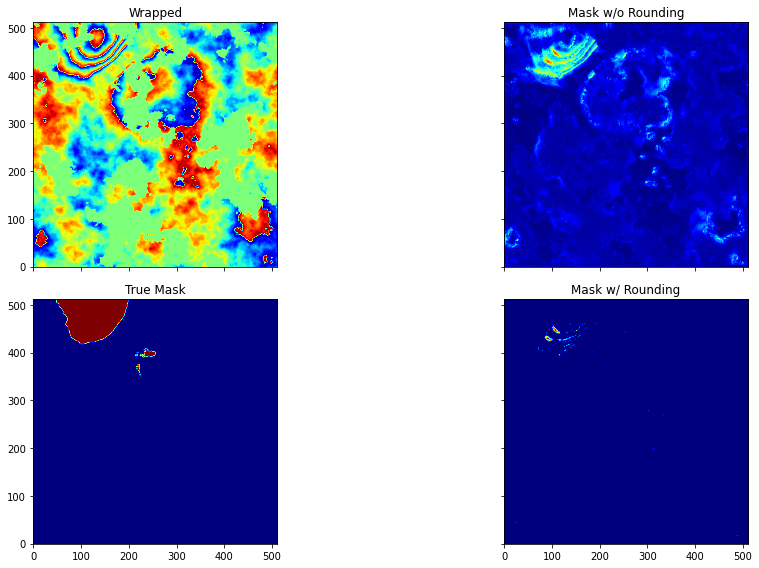

In [34]:
def eval_mask_model(model, event_type, seed, noise_only, round_mask, zero_output, tile_size, crop_size):

    if not noise_only:
        _, y, x, presence = gen_simulated_deformation(seed=seed, tile_size=tile_size, event_type=event_type)
    else:
        _, y, x, presence = gen_sim_noise(seed=seed, tile_size=tile_size)

    x      = x.reshape((1, tile_size, tile_size, 1))
    y_pred = np.float32(model.predict(x).reshape((crop_size, crop_size)))
    x      = x.reshape((tile_size, tile_size))

    y_pred_rounded = np.copy(y_pred)

    if round_mask:
        tolerance  = 0.7
        round_up   = y_pred >= tolerance
        round_down = y_pred <  tolerance
        y_pred_rounded[round_up]   = 1
        y_pred_rounded[round_down] = 0

    if zero_output:
        zeros    = x == 0
        y[zeros] = 0
        y_pred_rounded[zeros] = 0

    return x, y, y_pred, y_pred_rounded

event_type  = 'quake'
seed        = 0
noise_only  = False
round_mask  = True
zero_output = False

x, y, y_pred, y_pred_rounded = eval_mask_model(mask_model, event_type, seed, noise_only, round_mask, zero_output, tile_size, crop_size)

plot_imgs(x, y, y_pred, y_pred_rounded)

### Create Dataset of Simulated Events with Masks from the UNet

As mentioned before, it is possible to train the binary classification model on any dataset generated by make_simulated_dataset; however, each masking model may have slight quirks and imperfections which can result in worse performance when a binary model is expecting perfection. Thus, it is better to use the masking model to generate the masks for training the binary classification model. This is done by including the masking model's path in the function arguments.

In [35]:
amount     = 1000    # A size of ~1000 usually produces good results.
split      = 0.1
name       = "Test_Binary_Dataset" 
model_path = "data/output/models/checkpoints/" + model_name 

name, count, dir_name, _, _ = make_simulated_dataset(
    name,
    SYNTHETIC_DIR,
    amount,
    seed,
    tile_size,
    crop_size,
    model_path = model_path
)

SYNTHETIC_DIR.__str__() + '/' + dir_name

num_train, num_validation = split_dataset(SYNTHETIC_DIR.__str__() + '/' + dir_name, split)

print("")
print(f"Dataset Path:      {dataset_path}")
print(f"Train Amount:      {num_train}")
print(f"Validation Amount: {num_validation}")

Generated 10 of 100 simulated interferogram pairs.
Generated 20 of 100 simulated interferogram pairs.
Generated 30 of 100 simulated interferogram pairs.
Generated 40 of 100 simulated interferogram pairs.
Generated 50 of 100 simulated interferogram pairs.
Generated 60 of 100 simulated interferogram pairs.
Generated 70 of 100 simulated interferogram pairs.
Generated 80 of 100 simulated interferogram pairs.
Generated 90 of 100 simulated interferogram pairs.
Generated 100 of 100 simulated interferogram pairs.

Dataset Path:      /home/andrew/repos/AI-Event-Monitoring/data/working/synthetic/Test_Dataset_amount100_seed195546
Train Amount:      90
Validation Amount: 10


### Train the Binary Classification Model

Finally, we can train the binary classification model. This model is simple, being made up of only a couple convolutional layers and a dense layer, so it trains very fast. The default hyperparameters here should be sufficient for achieving satisfactory results. 

In [36]:
model_name_bin = "Binary_Test_Model"
model_type     = "eventnet"
dataset_path   = dataset_path
input_shape    = 512
epochs         = 5
filters        = 64
batch_size     = 1
learning_rate  = 5e-3
use_wandb      = False
using_aws      = False
using_jupyter  = True
logs_dir       = ""

class_model, class_history = train(
    model_name,
    dataset_path,
    model_type,
    input_shape,
    epochs,
    filters,
    batch_size,
    learning_rate,
    use_wandb,
    using_aws,
    using_jupyter,
    logs_dir
)

Epoch 1/5
91/92 [============================>.] - ETA: 0s - loss: 0.1479 - acc: 0.8352 - mean_absolute_error: 0.3180
Epoch 1: val_loss improved from inf to 0.05151, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:05:26.588391: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 6s 61ms/step - loss: 0.1463 - acc: 0.8370 - mean_absolute_error: 0.3145 - val_loss: 0.0515 - val_acc: 1.0000 - val_mean_absolute_error: 0.1663
Epoch 2/5
91/92 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9341 - mean_absolute_error: 0.1346
Epoch 2: val_loss improved from 0.05151 to 0.00093, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:05:32.193671: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 7s 79ms/step - loss: 0.0585 - acc: 0.9348 - mean_absolute_error: 0.1336 - val_loss: 9.3007e-04 - val_acc: 1.0000 - val_mean_absolute_error: 0.0231
Epoch 3/5
91/92 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9780 - mean_absolute_error: 0.0810
Epoch 3: val_loss improved from 0.00093 to 0.00059, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:05:39.410305: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 7s 75ms/step - loss: 0.0268 - acc: 0.9783 - mean_absolute_error: 0.0808 - val_loss: 5.8711e-04 - val_acc: 1.0000 - val_mean_absolute_error: 0.0177
Epoch 4/5
91/92 [============================>.] - ETA: 0s - loss: 0.0094 - acc: 0.9890 - mean_absolute_error: 0.0444
Epoch 4: val_loss improved from 0.00059 to 0.00027, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:05:46.368440: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 3s 32ms/step - loss: 0.0093 - acc: 0.9891 - mean_absolute_error: 0.0442 - val_loss: 2.7061e-04 - val_acc: 1.0000 - val_mean_absolute_error: 0.0119
Epoch 5/5
91/92 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 1.0000 - mean_absolute_error: 0.0224
Epoch 5: val_loss improved from 0.00027 to 0.00016, saving model to ./data/output/models/checkpoints/Test_Model


2022-11-22 21:05:49.690740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ./data/output/models/checkpoints/Test_Model/assets
92/92 [==============================] - 6s 67ms/step - loss: 0.0013 - acc: 1.0000 - mean_absolute_error: 0.0223 - val_loss: 1.5807e-04 - val_acc: 1.0000 - val_mean_absolute_error: 0.0090
INFO:tensorflow:Assets written to: ./data/output/models/Test_Model/assets


### Run Inference on a Simulated Event with the Binary Classification Model

Just like before, a great way to get a basic evaulation of this model is to use simulated events. However, this time we need to remember to get the mask from the masking model, rather than from gen_simulated_deformation or gen_sim_noise. 

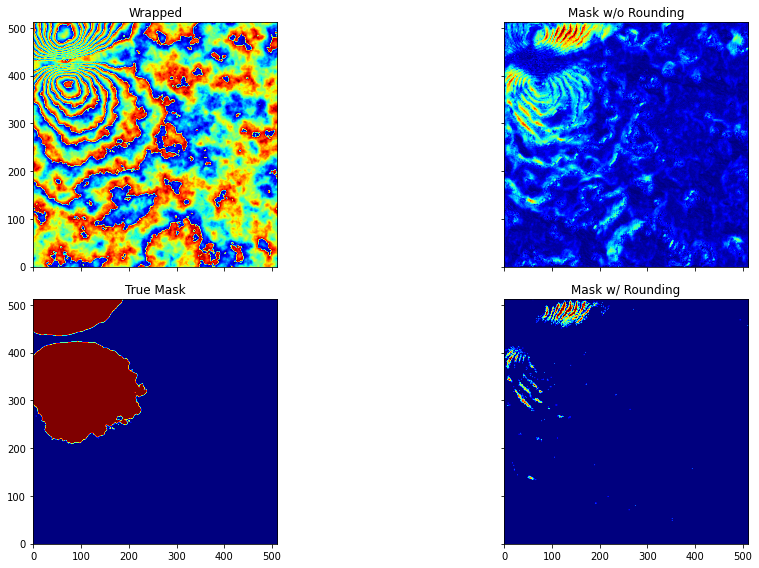

Event Prediction: [0.06573]


In [38]:
def eval_binary_model(mask_model, binary_model, event_type, seed, noise_only, round_mask, zero_output, tile_size, crop_size):

    wrapped, unwrapped, mask_pred, mask_pred_rounded = eval_mask_model(
        mask_model,
        event_type,
        seed,
        noise_only,
        round_mask,
        zero_output,
        tile_size,
        crop_size
    )

    presence_pred = binary_model.predict(mask_pred_rounded.reshape(1, tile_size, tile_size, 1))

    return wrapped, unwrapped, mask_pred, mask_pred_rounded, presence_pred

event_type  = 'quake'
seed        = 0
noise_only  = False
round_mask  = True
zero_output = False

wrapped, unwrapped, mask_pred, mask_pred_rounded, presence_pred = eval_binary_model(
    mask_model,
    class_model,
    event_type,
    seed,
    noise_only,
    round_mask,
    zero_output,
    tile_size,
    crop_size
)

plot_imgs(wrapped, unwrapped, mask_pred, mask_pred_rounded)

print(f"Event Prediction: {presence_pred[0]}")